In [ ]:
!nvidia-smi

Wed Feb  3 07:06:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import cv2
import glob
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch import cuda
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split

==> Preparing data..
./drive/MyDrive/MURA-v1.1
./drive/MyDrive/MURA-v1.1/train ./drive/MyDrive/MURA-v1.1/valid

=================Train subset=================
Size: 3601
Percentage from original data: 0.42976488841150495
Percentage of negatives: 1.0
Percentage of positives: 0.0
Number of patients: 1130


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


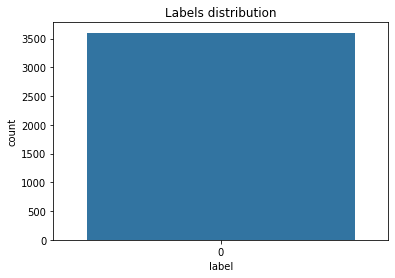


=============Validation subset===============
Size: 4778
Percentage from original data: 0.570235111588495
Percentage of negatives: 0.12766848053578903
Percentage of positives: 0.872331519464211
Number of patients: 1610


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


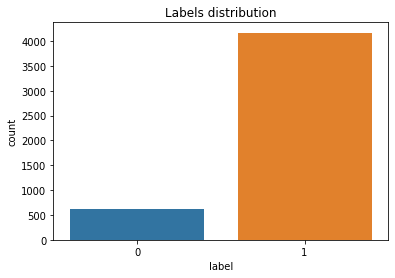

In [ ]:
print('==> Preparing data..')
from sklearn.model_selection import GroupShuffleSplit
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import glob
import re
import matplotlib.pyplot as plt
import seaborn as sns

class TrainValTestSplitter:

    def __init__(self, path_to_data, test=False, split='train/val', show_labels_dist=False, random_state=42):
        """
        Train-validation-test splitter, stores all the filenames
        :param path_to_data: for glob.glob to find all the images path
        :param show_labels_dist: show plot of distributions of labels
        """
        path_to_data = f'{path_to_data}/*/*/*'
        self.random_state = random_state
        self.show_labels_dist = show_labels_dist
        self.data = pd.DataFrame()
        self.data['path'] = glob.glob(path_to_data)
        self.data['label'] = self.data['path'].apply(lambda path: len(re.findall('positive', path)))
        self.data['patient'] = self.data['path'].apply(lambda path: re.findall('[0-9]{5}', path)[0])
        if test:
            self._split_stats(self.data)
        else:
            self._split_data(split)

    def _split_stats(self, df):
        print(f'Size: {len(df)}')
        print(f'Percentage from original data: {len(df)/len(self.data)}')
        print(f'Percentage of negatives: {len(df[df.label == 0])/len(df)}')
        print(f'Percentage of positives: {1-(len(df[df.label == 0])/len(df))}')
        print(f'Number of patients: {len(df.patient.unique())}')
        if self.show_labels_dist:
            import seaborn as sns
            sns.countplot(df['label'])
            plt.title('Labels distribution')
            plt.show()

    def train_val(self):
            # train | validate split
            splitter = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=self.random_state)
            negative_data = self.data[self.data.label == 0]
            generator = splitter.split(negative_data.label, groups=negative_data['patient'])
            idx_train, idx_validate_test = next(generator)

            print('\n=================Train subset=================')
            self.data_train = negative_data.iloc[idx_train, :].reset_index(drop=True)
            self._split_stats(self.data_train)
            
            # validate split
            print('\n=============Validation subset===============')
            data_val_test = pd.concat([self.data[self.data.label == 1], self.data.iloc[negative_data.iloc[idx_validate_test, :].index]]) 
            self.data_val = data_val_test.sample(len(data_val_test)).reset_index(drop=True)
            self._split_stats(data_val_test)
            
    def train_val_test(self): 
            # train | validate test split
            splitter = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=self.random_state)
            negative_data = self.data[self.data.label == 0]
            generator = splitter.split(negative_data.label, groups=negative_data['patient'])
            idx_train, idx_validate_test = next(generator)

            print('\n=================Train subset=================')
            data_val_test = pd.concat([self.data[self.data.label == 1], self.data.iloc[negative_data.iloc[idx_validate_test, :].index]])
            self.data_train = negative_data.iloc[idx_train, :].reset_index(drop=True)
            self._split_stats(data_val_test)

            # validate | test split
            data_val_test = pd.concat([self.data[self.data.label == 1], self.data.iloc[negative_data.iloc[idx_validate_test, :].index]])
            splitter = GroupShuffleSplit(n_splits=1, test_size=0.50, random_state=self.random_state)
            generator = splitter.split(data_val_test.label, groups=data_val_test['patient'])
            idx_val, idx_test = next(generator)

            print('\n=============Validation subset===============')
            self.data_val = data_val_test.iloc[idx_val, :]
            self.data_val = self.data_val.sample(len(self.data_val)).reset_index(drop=True)
            self._split_stats(self.data_val)

            print('\n=================Test subset=================')
            self.data_test = data_val_test.iloc[idx_test, :]
            self.data_test = self.data_test.sample(len(self.data_test)).reset_index(drop=True)
            self._split_stats(self.data_test)      
          
    def _split_data(self, split='train/val'):
        """
        Creates data_train, data_val, data_test dataframes with filenames
        """
        if split == 'train/val': self.train_val()
        elif split == 'train/val/test': self.train_val_test()

class MURASubset(Dataset):

    def __init__(self, filenames, transform=None, n_channels=1, true_labels=None, patients=None):
        """Initialization
        :param filenames: list of filenames, e.g. from TrainValTestSplitter
        :param true_labels: list of true labels (for validation and split)
        """
        self.transform = transform
        self.filenames = list(filenames)
        self.n_channels = n_channels
        self.true_labels = true_labels
        self.patients = patients

    def __len__(self) -> int:
        """Denotes the number of batches per epoch"""
        return len(self.filenames)

    def __getitem__(self, index) -> np.array:
        """Reads sample"""
        if self.n_channels == 1: image = cv2.imread(self.filenames[index])
        image = cv2.imread(self.filenames[index])
        label = self.true_labels[index] if self.true_labels is not None else None
        patient = self.patients[index] if self.true_labels is not None else None
        filenames = self.filenames[index]

        if self.transform:
            image = self.transform(image)

        return image, label, index

ROOT_PATH = './drive/MyDrive/MURA-v1.1'
print(ROOT_PATH)
DATA_PATH = f'{ROOT_PATH}/train'
VALID_PATH = f'{ROOT_PATH}/valid'
print(DATA_PATH, VALID_PATH)

run_params = {
    'pipeline': {
        'data_source': 'XR_SHOULDER',
    }
}

data_path = f'{DATA_PATH}/{run_params["pipeline"]["data_source"]}'
splitter = TrainValTestSplitter(path_to_data=data_path, test=False, split='train/val', show_labels_dist=True)

train_transform = transforms.Compose([
                                transforms.ToPILImage(),                                      
                                transforms.Resize((256,256)),
                                transforms.ToTensor()])

trainset = MURASubset(splitter.data_train.path, train_transform, n_channels=3, true_labels=splitter.data_train.label, patients=splitter.data_train.patient)
trainloader = DataLoader(trainset, batch_size=8, shuffle=True)
valset = MURASubset(splitter.data_val.path, train_transform, n_channels=3, true_labels=splitter.data_val.label, patients=splitter.data_val.patient)
valloader = DataLoader(valset, batch_size=32, shuffle=True)


In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(6,6))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs):
    out = torchvision.utils.make_grid(inputs[:16])
    imshow(out)

# Get a batch of training data
inp, tr, _ = next(iter(valloader))
show_databatch(inp)

In [ ]:
  
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models

import logging
import torch.nn as nn
import numpy as np


class BaseNet(nn.Module):
    """Base class for all neural networks."""

    def __init__(self):
        super().__init__()
        self.logger = logging.getLogger(self.__class__.__name__)
        self.rep_dim = None  # representation dimensionality, i.e. dim of the last layer

    def forward(self, *input):
        """
        Forward pass logic
        :return: Network output
        """
        raise NotImplementedError

    def summary(self):
        """Network summary."""
        net_parameters = filter(lambda p: p.requires_grad, self.parameters())
        params = sum([np.prod(p.size()) for p in net_parameters])
        self.logger.info('Trainable parameters: {}'.format(params))
        self.logger.info(self)

class Normalize(nn.Module):

    def __init__(self, power=2):
        super(Normalize, self).__init__()
        self.power = power

    def forward(self, x):
        norm = x.pow(self.power).sum(1, keepdim=True).pow(1. / self.power)
        out = x.div(norm)
        return out

class ResNet18(nn.Module):

    def __init__(self, rep_dim):
        super(ResNet18, self).__init__()
        
        model = models.resnet18(pretrained=True)
        self.conv1 = model.conv1
        self.bn1 = model.bn1
        self.relu = model.relu
        self.layer1 = model.layer1
        self.layer2 = model.layer2
        self.layer3 = model.layer3
        self.layer4 = model.layer4
        self.avgpool = model.avgpool
        self.fc = nn.Linear(in_features=512, out_features=rep_dim, bias=True)
        self.l2norm = Normalize(2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        feature = self.layer4(x)
        x = self.avgpool(feature)
        x = x.view(-1, 512)
        x = self.fc(x)
        x = self.l2norm(x)
        return x, feature
        
        
class UPBlock(nn.Module):

    def __init__(self, ich, och, upsample=False):
        super(UPBlock, self).__init__()
        
        self.upsample = upsample
        self.upsampleLayer = nn.Sequential(nn.Upsample(mode='bilinear', scale_factor=2, align_corners=True),
                                        nn.Conv2d(ich, och, kernel_size=1, bias=False),
                                        nn.BatchNorm2d(och, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)) if upsample else  None
                                        
        self.conv1 = nn.Sequential(nn.Conv2d(ich, och, 3, 1, 1, bias=False),
                nn.BatchNorm2d(och, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
        self.relu = nn.ReLU(True)           
        self.conv2 = nn.Conv2d(och, och, 3, 1, 1, bias=False)
        self.bnrm = nn.BatchNorm2d(och, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                                    
    def forward(self, x):
        if self.upsample:
            identity = self.upsampleLayer(x)
            out = identity
        else:
            identity = x
            out = self.conv1(x)
            
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bnrm(out)
        
        out += identity
        out = self.relu(out)
        return out
        
        
class ResNetDecoderSymmetric(nn.Module):

    def __init__(self):
        super(ResNetDecoderSymmetric, self).__init__()
        
        self.decoder = nn.Sequential(UPBlock(512, 512),
                                    UPBlock(512, 512),
                                    UPBlock(512, 256, True),
                                    UPBlock(256, 256),
                                    UPBlock(256, 128, True),
                                    UPBlock(128, 128),
                                    UPBlock(128, 64, True),
                                    UPBlock(64, 64))
                                    
        self.output = nn.Sequential(nn.Upsample(mode='bilinear', scale_factor=2, align_corners=True),
                        nn.Conv2d(64, 3, kernel_size=1, bias=False),
                        nn.Tanh())                               
                                    
    def forward(self, x):
        out = self.decoder(x)
        out = self.output(out)
        return out


class ResNet18Autoencoder(BaseNet):

    def __init__(self, rep_dim):
        super().__init__()
        self.encoder = ResNet18(rep_dim)
        self.decoder = ResNetDecoderSymmetric()
        # self.encoder2 = ResNet18(rep_dim)
        
    def forward(self, x):
        latent1, feature = self.encoder(x)
        rec_image = self.decoder(feature)
        #latent2, _ = self.encoder2(rec_image)
        return latent1, rec_image

In [ ]:

# Refer to https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class Normalize(nn.Module):

    def __init__(self, power=2):
        super(Normalize, self).__init__()
        self.power = power

    def forward(self, x):
        norm = x.pow(self.power).sum(1, keepdim=True).pow(1. / self.power)
        out = x.div(norm)
        return out

class Model(nn.Module):
    """ ITAE model """

    def __init__(self, n_channels=1, h_dim=756, z_dim=512, bilinear=True):
        super(Model, self).__init__()
        self.h_dim = h_dim
        self.z_dim = z_dim
        self.in_conv = DoubleConv(1, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        #self.down4 = Down(512, 512)
        self.flatten = nn.Flatten()
        self.z = nn.Sequential(nn.Linear(131072,self.h_dim),nn.ReLU(),nn.Linear(self.h_dim,self.z_dim))
        self.l2 = Normalize()
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64)
        # seems that the structure in paper does not contain 'tanh'
        self.out_conv = nn.Conv2d(64, n_channels, kernel_size=3, stride=1, padding=1, bias=False)# Unet use 1*1conv to be out_conv

    def forward(self, x):
        x0_2 = self.in_conv(x)
        x1_3 = self.down1(x0_2)
        x2_3 = self.down2(x1_3)
        x3_3 = self.down3(x2_3)
        x_flat = self.flatten(x3_3)
        z = self.z(x_flat)
        l2 = self.l2(z).unsqueeze(2).unsqueeze(3)
        x = self.up1(l2, x3_3)
        x = self.up2(x, x2_3)
        x = self.up3(x, x1_3)
        x = self.up4(x, x0_2)
        out = torch.tanh(self.out_conv(x))
        return l2.squeeze(), out

In [ ]:
import torch
import torch.nn as nn


class Double_conv(nn.Module):
    """
    Apply a double convolution on the input x
    args:
        - ich: Number of channel of the input
        - och: Number of channel of the output
    """

    def __init__(self, ich, och):
        super(Double_conv, self).__init__()

        self.conv = nn.Sequential(nn.Conv2d(ich, och, 3, 1, 1, bias=False),
                                nn.BatchNorm2d(och),
                                nn.ReLU(),
                                nn.Conv2d(och, och, 3, 1, 1, bias=False),
                                nn.BatchNorm2d(och),
                                nn.ReLU())
        """
        self.conv = nn.Sequential(nn.Conv2d(ich, och, 3, 1, 1, bias=False),
                                  nn.LeakyReLU(0.1),
                                  nn.Conv2d(och, och, 3, 1, 1, bias=False),
                                  nn.LeakyReLU(0.1))
        """
                                
    def forward(self, x):
        x = self.conv(x)
        return x
        
        
class Down(nn.Module):

    """
    Apply an encoding convolution, divides the image size by two
    args:
        - ich: Number of channel of the input
        - och: Number of channel of the output
    """
    def __init__(self, ich, och):
        super(Down, self).__init__()
        
        self.pool = nn.MaxPool2d(2)
        self.conv = Double_conv(ich, och)
        
    def forward(self,x):
        x = self.pool(x)
        x = self.conv(x)
        return x
        
class Up(nn.Module):

    """
    Apply a decoding deconvolution, multiplies the image size by two
    args:
        - ich: Number of channel of the input
        - och: Number of channel of the output
    """
    def __init__(self, ich, och):
        super(Up, self).__init__()
        self.up = nn.Sequential(nn.Upsample(mode='bilinear', scale_factor=2, align_corners=True),
                                nn.Conv2d(ich, ich // 2, kernel_size=1, bias=False),
                                nn.BatchNorm2d(ich // 2))
        """
        self.up = nn.Sequential(nn.Upsample(mode='bilinear', scale_factor=2, align_corners=True),
                                nn.Conv2d(ich, ich // 2, kernel_size=1, bias=False))
        """
        #self.conv = Double_conv(och + ich // 2, och)
        self.conv = Double_conv(ich // 2, och)
        
    def forward(self, enc_layer, dec_layer):
        dec = self.up(dec_layer)
        #x = torch.cat([enc_layer, dec], dim=1)
        #x = self.conv(x)
        x = self.conv(dec)
        return x        

class Normalize(nn.Module):

    def __init__(self, power=2):
        super(Normalize, self).__init__()
        self.power = power

    def forward(self, x):
        norm = x.pow(self.power).sum(1, keepdim=True).pow(1. / self.power)
        out = x.div(norm)
        return out

class UNET(nn.Module):

    """
    Implements a unet network with convolutional encoding and deconvolutional decoding.
    The forward method implements skip connections between encoder and decoder to keep consistency in the features
    arg:
        n_classes: The number of channel output
    """
    def __init__(self, rep_dim, inp_channel, out_channel):
        super(UNET, self).__init__()

        self.input = Double_conv(inp_channel, 32)
        self.e1 = Down(32, 64)
        self.e2 = Down(64, 128)
        self.e3 = Down(128, 256)
        self.e4 = Down(256, 512)
        self.e5 = Down(512, 1024)
        self.feat = nn.Conv2d(1024, rep_dim, 8, bias=False)
        self.l2norm = Normalize()

        self.defeat = nn.ConvTranspose2d(rep_dim, 1024, 8, bias=False)
        self.d2 = Up(1024, 512)
        self.d3 = Up(512, 256)
        self.d4 = Up(256, 128)
        self.d5 = Up(128, 64)
        self.d6 = Up(64, 32)
        
        self.final = nn.Conv2d(32, out_channel, 1, 1, 0, bias=False)
        self.activation = nn.ReLU()
        
    def forward(self, x):
        e1 = self.input(x)
        e2 = self.e1(e1)
        e3 = self.e2(e2)
        e4 = self.e3(e3)
        e5 = self.e4(e4)
        e6 = self.e5(e5)
        feature = self.l2norm(self.feat(e6))
        defeature = self.defeat(feature)
        x = self.d2(e5, defeature)
        x = self.d3(e4, x)
        x = self.d4(e3, x)
        x = self.d5(e2, x)
        x = self.d6(e1, x)
        x = self.final(x)
        x = self.activation(x)
        
        return feature.squeeze(), x

In [ ]:
#model = Model(1,1024,128,True).to('cuda')
#model = UNET(256,1,1).to('cuda')
model = ResNet18Autoencoder(256).to('cuda')
#model = UNet(1,1,512,False).to('cuda')

In [ ]:
from torchsummary import summary
import torch.nn.functional as F
summary(model, (3,256,256), 2, 'cuda')

In [ ]:
def plotCurves(stats):
    for c in ['train_loss','test_loss']:
        try:plt.plot(stats[c], label=c)
        except: pass
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.title('Training Loss Curve')
    plt.show()
    try:
      for c in ['AUC score','AP score']:
        plt.plot(stats[c], label=c)
      plt.legend()
      plt.xlabel('Epochs')
      plt.ylabel('AUC')
      plt.title('AUC Curve')
      plt.show()
    except: pass

In [ ]:
import torch.nn.functional as F

In [ ]:
import logging
import time
import torch
import torch.optim as optim
import numpy as np
import math
from tqdm import tqdm

class Solver():

    def __init__(self, tr_dataset, te_dataset, network, k : int, lr: float, n_epochs: int, rep_dim:int,
                 weight_decay: float, device: str, w_rec : float):

        self.model = network.to(device)
        self.trainloader = tr_dataset
        self.testloader = te_dataset
        self.n_epochs = n_epochs
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.rec_loss = torch.nn.L1Loss()
        self.feat_loss = torch.nn.MSELoss()
        self.best_score = 0
        self.w_rec = 0.5
        self.min_loss = 0.003
        self.k = k
        self.device=device
        self.logger = logging.getLogger()
        self.memory = torch.randn(size=(len(self.trainloader.dataset), rep_dim)).to(self.device)

    def train(self, load=False):
        stats = []
        print('Started Training..\n')
        if load: 
          print('Loading model....')
          self.model.load_state_dict(torch.load('./drive/MyDrive/model.tar'))
        for e in range(1, self.n_epochs+1):
            loss = 0
            latent = torch.randn(size=(len(self.trainloader.dataset), 512)).to(self.device)
            self.model.train()
            for i, (img, _, indexes) in enumerate(self.trainloader):
                inp =  img.clone().type(torch.float)
                inputs = inp.to(self.device)
                self.optimizer.zero_grad()

                latent1, rec_images = self.model(inputs)
                rec_loss = self.w_rec*self.rec_loss(inputs, rec_images)
                rec_loss.backward()

                loss += rec_loss.item()*inputs.shape[0]
                self.optimizer.step()

                self.memory[indexes] = latent1
                if i  == 449:
                    show_databatch(inputs.detach().cpu())
                    show_databatch(rec_images.detach().cpu())

            t_loss = loss/len(self.trainloader.dataset)
            
            if e > 10:
              score, ap_score, test_loss = self.test()
              stats.append([t_loss, test_loss, score, ap_score])
              stat = pd.DataFrame(stats, columns=['train_loss', 'test_loss', 'AUC score', 'AP score'])
              if ap_score > 0.50: 
                torch.save({'state_dict' : self.model.state_dict()}, 'state_dict.pt')
                #torch.save(self.model, 'model.pt')
              if test_loss < self.min_loss:
                  self.min_loss = test_loss
                  torch.save({'state_dict' : self.model.state_dict()}, './drive/MyDrive/model.tar')
              print("Epoch %d/%d : Train Loss = %f | Test Loss = %f | AUC = %.4f | AP = %.4f " % (e, self.n_epochs, t_loss, test_loss, score, ap_score))
            else:
              stats.append([t_loss])
              stat = pd.DataFrame(stats, columns=['train_loss'])
              print("Epoch %d/%d : Train Loss = %f | " % (e, self.n_epochs, t_loss))          
            if e % 10 == 0: plotCurves(stat)


    def test(self, load=False, load_memory=False):

        idx_label_score = []
        self.model.eval()
        if load: self.model.load_state_dict(torch.load('model.pt'))
        with torch.no_grad():
            if load_memory:
                for i, (img, _, indexes) in enumerate(self.trainloader):
                    inp =  img.clone().type(torch.float)
                    inputs = inp.to(self.device)
                    latent1, rec_images = self.model(inputs)

                    self.memory[indexes] = latent1

            loss = 0
            trainfeatures = self.memory.t()
            for i, data in enumerate(self.testloader):
                imgs, labels, _ = data
                inputs =  imgs.clone().type(torch.float).to(self.device)
                latent1, rec_images = self.model(inputs)

                dist = torch.acos(torch.mm(latent1, trainfeatures)) / math.pi

                scores, _ = dist.topk(self.k, dim=1, largest=False, sorted=True)
                scores = torch.mean(scores, dim=1)
                loss += self.rec_loss(inputs, rec_images).item()*inputs.shape[0]

                # Save tuple of (label, score) in a list
                idx_label_score += list(zip(
                                            labels.cpu().data.numpy().tolist(),
                                            scores.cpu().data.numpy().tolist()))
        print(scores.max(), scores.min())
        self.test_scores = idx_label_score
        test_loss = loss / len(self.testloader.dataset)
        # Compute AUC
        labels, scores = zip(*idx_label_score)
        scores = (scores - np.min(scores)) / (np.max(scores) - np.min(scores))
        labels = np.array(labels)
        scores = np.array(scores)
        return roc_auc_score(labels, scores), average_precision_score(labels, scores), test_loss

In [ ]:
t = Solver(trainloader, valloader, model, 100, 1e-3, 500, 256, 0.5, 'cuda', 1)

In [ ]:
t.train()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3601 samples in 0.090s...
[t-SNE] Computed neighbors for 3601 samples in 4.621s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3601
[t-SNE] Computed conditional probabilities for sample 2000 / 3601
[t-SNE] Computed conditional probabilities for sample 3000 / 3601
[t-SNE] Computed conditional probabilities for sample 3601 / 3601
[t-SNE] Mean sigma: 0.084255
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.407837
[t-SNE] KL divergence after 5000 iterations: 1.544995


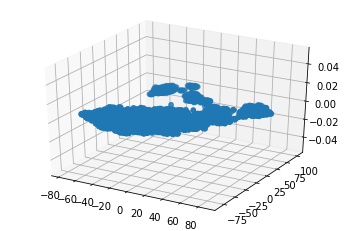

<Figure size 864x864 with 0 Axes>

In [ ]:
# run t-SNE
from sklearn.manifold import TSNE
# perplexity parameter can be changed based on the input datatset
# dataset with larger number of variables requires larger perplexity
# set this value between 5 and 50 (sklearn documentation)
# verbose=1 displays run time messages
# set n_iter sufficiently high to resolve the well stabilized cluster
# get embeddings
tsne_em = TSNE(n_components=2, perplexity=30.0, n_iter=5000, verbose=1).fit_transform(t.memory.detach().cpu().numpy())

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.figure(figsize=(12,12))
ax.scatter(*zip(*tsne_em))
plt.show()



In [ ]:
# plot t-SNE clusters
from bioinfokit.visuz import cluster
color_class = ['0']
cluster.tsneplot(score=tsne_em, colordot=('#713e5a'), 
    legendpos='upper right', legendanchor=(1.15, 1) )
# plot will be saved in same directory (tsne_2d.png) 

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


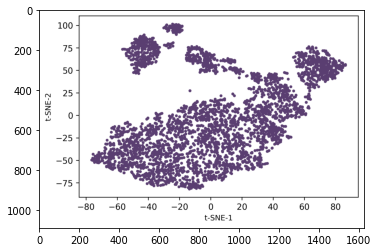

In [ ]:
import cv2
import matplotlib.pyplot as plt
im = cv2.imread('tsne_2d.png')
plt.imshow(im)